# Milestone 2 Phase 2

By : Maheswara Sinatriyo

Batch : HCK-001

## Problem Statement

Horizon park is one of the biggest open field park in australia. Our park is very vast and connected directly into the wilderness, this provides our visitor with thrill of adventure and exploration. But this comes with an issues as we want to preserve the original ecology on the area, thus there will still be a lot of wild animals. That is why we are proposing a robot animal trainer backed by our advance AI that can identify and handle wild animals.

DATASET: https://www.kaggle.com/datasets/andrewmvd/animal-faces/code

Deployment: https://animal-face-detection-mahes.herokuapp.com

## Import Libraries

In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf
import pickle
import random as rnd
from PIL import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,roc_auc_score,precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

np.random.seed(1337)
tf.random.set_seed(1337)


## Data Loading

In [2]:
os.listdir('Images')

['inference', 'train', 'val']

In [3]:
main_path= 'Images'

In [4]:
train_path = os.path.join(main_path, 'train')
val_path = os.path.join(main_path, 'val')

In [5]:
print('train set: \n' + '='*50)
num_cat= len(os.listdir(os.path.join(train_path, 'cat')))
num_dog= len(os.listdir(os.path.join(train_path, 'dog')))
num_wild= len(os.listdir(os.path.join(train_path, 'wild')))
print(f'Numer of Cat Image= {num_cat}')
print(f'Number of Dog Image= {num_dog}')
print(f'Number of Wild Image= {num_wild}')

train set: 
Numer of Cat Image= 5153
Number of Dog Image= 4739
Number of Wild Image= 4738


In [6]:
train_cat = glob.glob(train_path+"/cat/*.jpg")
train_dog = glob.glob(train_path+"/dog/*.jpg")
train_wild = glob.glob(train_path+"/wild/*.jpg")

In [7]:
val_cat = glob.glob(val_path+"/cat/*.jpg")
val_dog = glob.glob(val_path+"/dog/*.jpg")
val_wild = glob.glob(val_path+"/wild/*.jpg")

In [8]:
train_df = pd.DataFrame()
val_df = pd.DataFrame()

In [9]:
train_df['images'] = os.listdir(train_path+'/cat') + os.listdir(train_path+'/dog') + os.listdir(train_path+'/wild')
val_df['images'] = os.listdir(val_path+'/cat') + os.listdir(val_path+'/dog') + os.listdir(val_path+'/wild')

In [10]:
labels = []
paths = []
for image in train_df['images']:
    class_ = image.split('_')[1]
    labels.append(class_)
    paths.append(train_path+'/'+class_+'/'+image)


In [11]:
train_df['label'] = labels
train_df['path'] = paths

In [12]:
labels = []
paths = []
for image in val_df['images']:
    class_ = image.split('_')[1]
    labels.append(class_)
    paths.append(val_path+'/'+class_+'/'+image)

In [13]:
val_df['label'] = labels
val_df['path'] = paths

In [14]:
train_df.head()

,images,label,path
0,flickr_cat_000002.jpg,cat,Images\train/cat/flickr_cat_000002.jpg
1,flickr_cat_000003.jpg,cat,Images\train/cat/flickr_cat_000003.jpg
2,flickr_cat_000004.jpg,cat,Images\train/cat/flickr_cat_000004.jpg
3,flickr_cat_000005.jpg,cat,Images\train/cat/flickr_cat_000005.jpg
4,flickr_cat_000006.jpg,cat,Images\train/cat/flickr_cat_000006.jpg


In [15]:
train_image = np.array([])
val_image = np.array([])

In [16]:
# for i in range(len(train_df)):
#     train_image = np.append(train_image,np.array(Image.open(train_df['path'][i])))

In [17]:
# for i in range(len(val_df)):
#     val_image = np.append(val_image,np.array(Image.open(val_df['path'][i])))

## EDA

In [18]:
train_df.isnull().sum()

images    0
label     0
path      0
dtype: int64

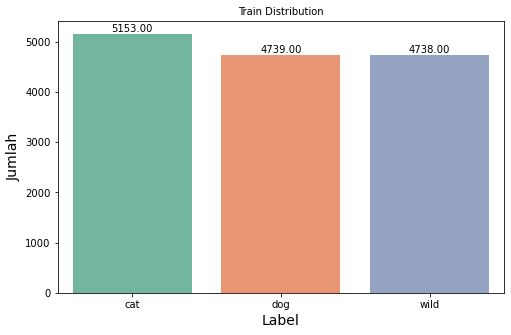

In [19]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

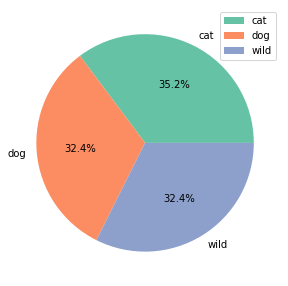

In [20]:
plt.figure(figsize=(5,5))
class_cnt = train_df.groupby(train_df['label']).size().reset_index(name = 'counts')
colors = sns.color_palette('Set2')[0:9]
plt.pie(class_cnt['counts'], labels=class_cnt['label'], colors=colors, autopct='%1.1f%%')
plt.legend(loc='upper right')
plt.show()

based on the data distribution above, we can see that the image data are balanced between cats, dogs, and wild animals at around 5k data each.

In [21]:
val_df.isnull().sum()

images    0
label     0
path      0
dtype: int64

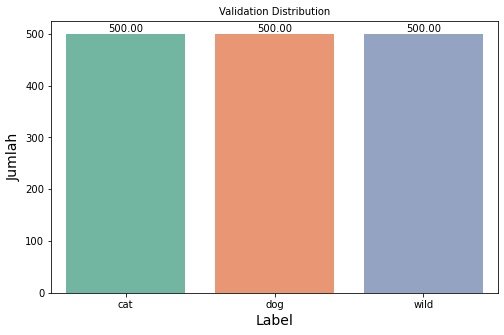

In [22]:
visualize_data(val_df, 'Validation')

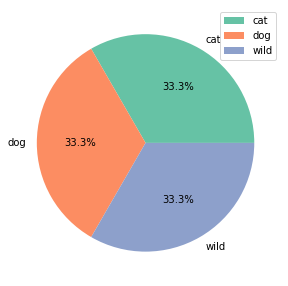

In [23]:
plt.figure(figsize=(5,5))
class_cnt = val_df.groupby(val_df['label']).size().reset_index(name = 'counts')
colors = sns.color_palette('Set2')[0:9]
plt.pie(class_cnt['counts'], labels=class_cnt['label'], colors=colors, autopct='%1.1f%%')
plt.legend(loc='upper right')
plt.show()

the validation data has exact 500 data for each category

In [24]:
img1 = np.array(Image.open(train_df['path'][0]))
img1.shape

(512, 512, 3)

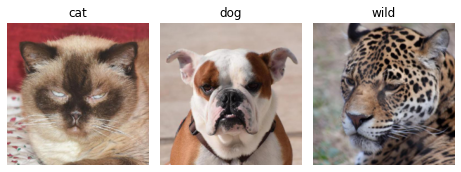

In [25]:
plt.figure(figsize = (15,12))
for idx,i in enumerate(train_df.label.unique()):
    plt.subplot(4,7,idx+1)
    df = train_df[train_df['label'] ==i].reset_index(drop = True)
    image_path = df.loc[rnd.randint(0, len(df))-1,'path']
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
plt.tight_layout()
plt.show()

In [26]:
def plot_species(df,animal_name):
    plt.figure(figsize = (12,12))
    species_df = df[df['label'] == animal_name].reset_index(drop = True)
    plt.suptitle(animal_name)
    for idx,i in enumerate(np.random.choice(species_df['path'],32)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

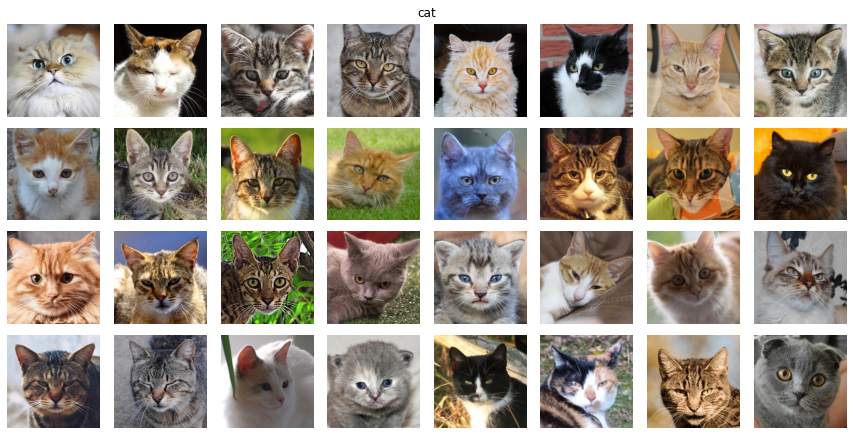

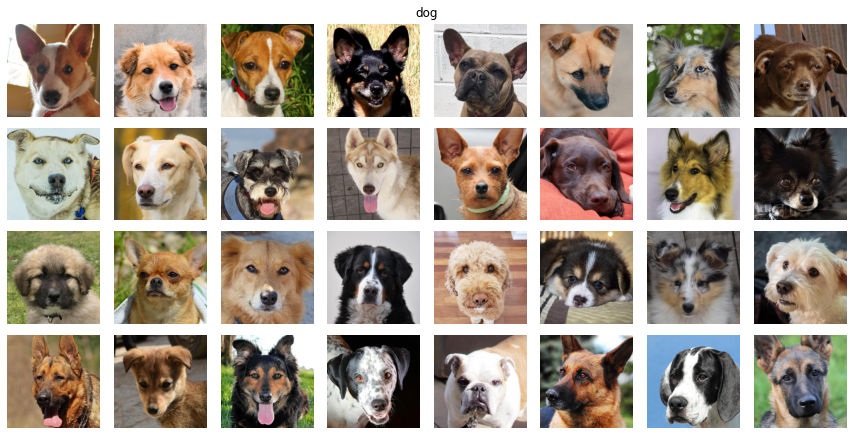

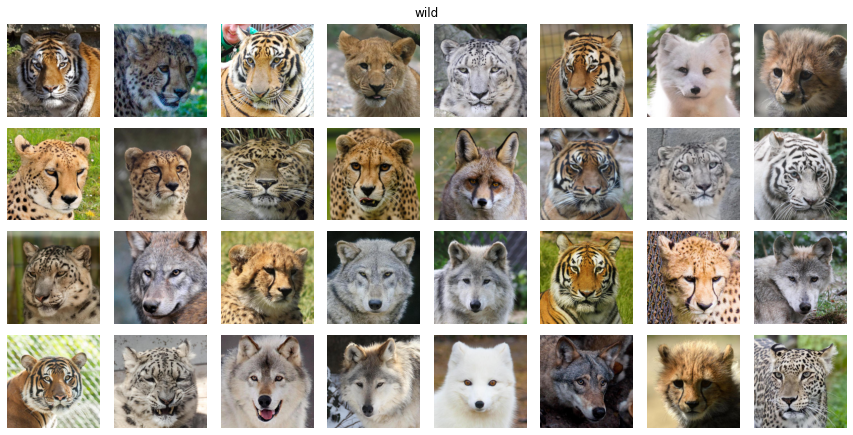

In [27]:
for animal_name in train_df['label'].unique():
    plot_species(train_df , animal_name)

as we can see that both cat, dog, and wild images has various type of breeds, but in general the image pose are similar, they all are looking into the camera. This lack of pose variety could pose an issues when we want to predict animal face with different pose (Ex: Laying on their backs, to the side, etc), thus we will be doing image augmentation later on in our pipeline. We can also see that the image types of wild animals arent just random wild animals, most of the images consist of canine and feline such as wolf, fox, lion, tiger, etc. 

## Preprocessing

### Augmentation

In [28]:
img_height= 224
img_width= 224
SEED = 1337
BATCH = 64

In [29]:
def train_val_generators(TRAINING_DIR,VALIDATION_DIR):
    train_datagen = ImageDataGenerator( rescale=1./255,
                                        rotation_range=0.1,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2)

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,batch_size=BATCH,
                                                        class_mode='categorical',target_size=(img_height,img_width),seed=SEED)

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,batch_size=BATCH,
                                                                    class_mode='categorical',target_size=(img_height,img_width),seed=SEED)

    return train_generator, validation_generator

this is our pipeline, it does a lot of things for us such as rescaling, resizing and augmenting the data, the batch for our model is also set here. We will be using 64 batch for our base model.

In [30]:
train_image, val_image = train_val_generators(train_path,val_path)

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


here we confirm that we have 14630 train data and 1500 val data

In [31]:
train_image.class_indices

{'cat': 0, 'dog': 1, 'wild': 2}

In [32]:
val_image.class_indices

{'cat': 0, 'dog': 1, 'wild': 2}

In [33]:
train_image[0]

(array([[[[0.4784314 , 0.47058827, 0.3803922 ],
          [0.4784314 , 0.47058827, 0.3803922 ],
          [0.4784314 , 0.47079116, 0.38049364],
          ...,
          [0.454902  , 0.41960788, 0.30588236],
          [0.454902  , 0.41960788, 0.30588236],
          [0.454902  , 0.41960788, 0.30588236]],
 
         [[0.4784314 , 0.47058827, 0.3803922 ],
          [0.4784314 , 0.47058827, 0.3803922 ],
          [0.4784314 , 0.47079214, 0.38049412],
          ...,
          [0.454902  , 0.41960788, 0.30588236],
          [0.454902  , 0.41960788, 0.30588236],
          [0.454902  , 0.41960788, 0.30588236]],
 
         [[0.4784314 , 0.47058827, 0.3803922 ],
          [0.4784314 , 0.47058827, 0.3803922 ],
          [0.4784314 , 0.4707931 , 0.3804946 ],
          ...,
          [0.454902  , 0.41960788, 0.30588236],
          [0.454902  , 0.41960788, 0.30588236],
          [0.454902  , 0.41960788, 0.30588236]],
 
         ...,
 
         [[0.44744048, 0.41606793, 0.32587183],
          [0.45120

In [34]:
val_image[0]

(array([[[[0.77647066, 0.72156864, 0.58431375],
          [0.78823537, 0.73333335, 0.59607846],
          [0.77647066, 0.72156864, 0.58431375],
          ...,
          [0.854902  , 0.80392164, 0.6784314 ],
          [0.8862746 , 0.8313726 , 0.7254902 ],
          [0.93725497, 0.882353  , 0.7803922 ]],
 
         [[0.79215693, 0.7372549 , 0.6       ],
          [0.8196079 , 0.76470596, 0.627451  ],
          [0.82745105, 0.7725491 , 0.63529414],
          ...,
          [0.8745099 , 0.8235295 , 0.69803923],
          [0.9450981 , 0.89019614, 0.7843138 ],
          [0.95294124, 0.8980393 , 0.7960785 ]],
 
         [[0.82745105, 0.7725491 , 0.63529414],
          [0.81568635, 0.7607844 , 0.62352943],
          [0.8313726 , 0.77647066, 0.6392157 ],
          ...,
          [0.9215687 , 0.8705883 , 0.74509805],
          [0.9294118 , 0.8745099 , 0.7686275 ],
          [0.9450981 , 0.89019614, 0.78823537]],
 
         ...,
 
         [[0.90196085, 0.8431373 , 0.7294118 ],
          [0.81960

### Target Encoding for train and val

#### Train

In [35]:
y_train = pd.DataFrame()
y_train['label'] = train_df['label']
y_train

,label
0,cat
1,cat
2,cat
3,cat
4,cat
...,...
14625,wild
14626,wild
14627,wild
14628,wild


this is our label dataset that we will be using later on for the classification report, but first we need to encode this label using one hot encoder

In [36]:
ohe = OneHotEncoder()

In [37]:
y_train_enc = ohe.fit_transform(y_train)
y_train_enc

<14630x3 sparse matrix of type '<class 'numpy.float64'>'
	with 14630 stored elements in Compressed Sparse Row format>

In [38]:
ohe.get_feature_names()

array(['x0_cat', 'x0_dog', 'x0_wild'], dtype=object)

#### Val

In [39]:
y_val = pd.DataFrame()
y_val['label'] = val_df['label']
y_val

,label
0,cat
1,cat
2,cat
3,cat
4,cat
...,...
1495,wild
1496,wild
1497,wild
1498,wild


In [40]:
y_val_enc = ohe.transform(y_val)
y_val_enc

<1500x3 sparse matrix of type '<class 'numpy.float64'>'
	with 1500 stored elements in Compressed Sparse Row format>

we have succeeded in encoding our train and val target label

## Modeling

### Base Model

In [41]:
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
]

In [42]:
inputs= [img_height,img_width,3]

model= Sequential()

#Conv 1, bisa tambahkan kernel_initializer
model.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
model.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Flatten())
model.add(Dense(units= 128, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [45]:
history= model.fit(train_image, batch_size= 64, 
                           epochs= 5, validation_data= val_image,
                           callbacks= callbacks1)

Epoch 1/5
229/229 [==============================] - 229s 998ms/step - loss: 0.8048 - accuracy: 0.6187 - val_loss: 0.3994 - val_accuracy: 0.8353
Epoch 2/5
229/229 [==============================] - 201s 877ms/step - loss: 0.4377 - accuracy: 0.8284 - val_loss: 0.2782 - val_accuracy: 0.9080
Epoch 3/5
229/229 [==============================] - 201s 878ms/step - loss: 0.3397 - accuracy: 0.8721 - val_loss: 0.3314 - val_accuracy: 0.8807
Epoch 4/5
229/229 [==============================] - 201s 878ms/step - loss: 0.2953 - accuracy: 0.8893 - val_loss: 0.2516 - val_accuracy: 0.9133
Epoch 5/5
229/229 [==============================] - 202s 883ms/step - loss: 0.2595 - accuracy: 0.9032 - val_loss: 0.1546 - val_accuracy: 0.9380


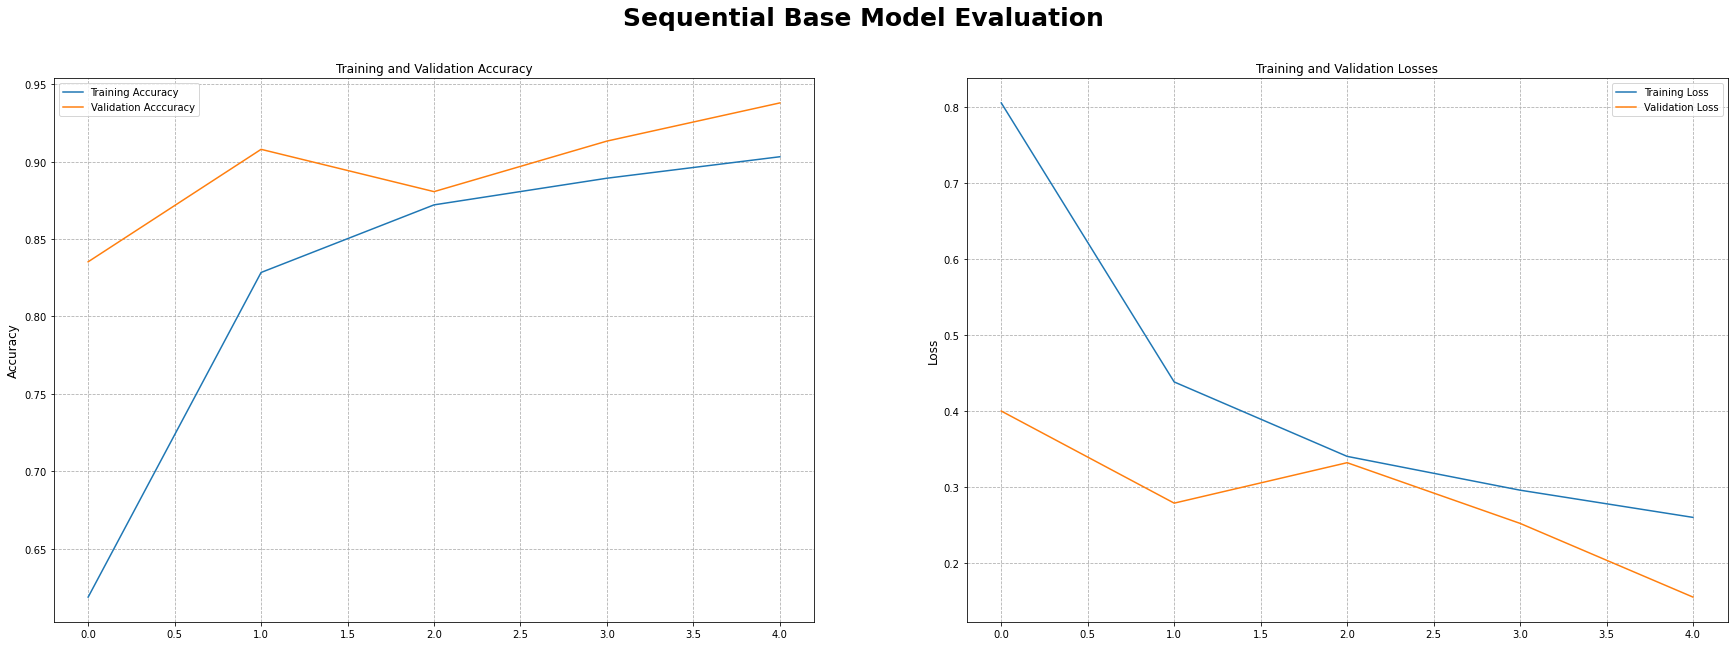

In [46]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Base Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

This is the result of the CNN base model training using sequential API. Since tihs is a base model no hyperparameter tuning is applied at this phase. For the base model I used 3 convolutional layer with 16, 32, and 64 filters. There is only 1 hidden layers with 128 neurons. Adam optimizer and relu activation is used with 64 batch size, in which the batch size was set in the preprocessing pipeline. There are 5 epoch, and we can see that the results keep on increasing, we could potentially get a better score by simply increasing the epoch. But overall, based on the graph between the train data and the validation data, the validation data has a better result compared to the training data but not by much, which we can conclude that the result are fit. But I still believe that we can achieve a better result by doing hyperparameter tuning.

### Tuned Model

In [47]:
img_height= 224
img_width= 224
SEED = 1337
BATCH2 = 8

since we use pipeline for our data loading, we will be redoing the pipeline in order to change our batch size for model improvement. Here we are changing the batch size to 8

In [65]:
def train_val_generators(TRAINING_DIR,VALIDATION_DIR):
    train_datagen = ImageDataGenerator( rescale=1./255,
                                        rotation_range=0.1,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2)

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,batch_size=BATCH2,
                                                        class_mode='categorical',target_size=(img_height,img_width),seed=SEED)

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,batch_size=BATCH2,
                                                                    class_mode='categorical',target_size=(img_height,img_width),seed=SEED)

    return train_generator, validation_generator

In [66]:
train_image2, val_image2 = train_val_generators(train_path,val_path)

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [67]:
train_image2.class_indices

{'cat': 0, 'dog': 1, 'wild': 2}

In [68]:
inputs= [img_height,img_width,3]

model_tune= Sequential()

#Conv 1, bisa tambahkan kernel_initializer
model_tune.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model_tune.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model_tune.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
model_tune.add(MaxPooling2D(pool_size=2, strides=2,))

#Conv 3
model_tune.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model_tune.add(MaxPooling2D(pool_size=2, strides=2))


model_tune.add(Flatten())
# model_tune.add(Dense(units= 256, activation='relu'))
model_tune.add(Dense(units= 128, activation='relu'))
model_tune.add(Dense(units= 64, activation='relu'))
model_tune.add(Dense(units= 32, activation='relu'))
# model_tune.add(Dense(units= 16, activation='relu'))
model_tune.add(Dense(units=3, activation='softmax'))

In [69]:
model_tune.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 64)      

In [70]:
model_tune.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics= ['accuracy'])

In [71]:
history_tune= model_tune.fit(train_image2, epochs= 25, validation_data= val_image2, callbacks= callbacks1) #bisa atur verbose

Epoch 1/25
1829/1829 [==============================] - 219s 120ms/step - loss: 0.7000 - accuracy: 0.6830 - val_loss: 0.3059 - val_accuracy: 0.8833
Epoch 2/25
1829/1829 [==============================] - 218s 119ms/step - loss: 0.3663 - accuracy: 0.8575 - val_loss: 0.2201 - val_accuracy: 0.9193
Epoch 3/25
1829/1829 [==============================] - 206s 112ms/step - loss: 0.2892 - accuracy: 0.8918 - val_loss: 0.2054 - val_accuracy: 0.9273
Epoch 4/25
1829/1829 [==============================] - 207s 113ms/step - loss: 0.2368 - accuracy: 0.9126 - val_loss: 0.1759 - val_accuracy: 0.9420
Epoch 5/25
1829/1829 [==============================] - 201s 110ms/step - loss: 0.2054 - accuracy: 0.9231 - val_loss: 0.1513 - val_accuracy: 0.9507
Epoch 6/25
1829/1829 [==============================] - 235s 128ms/step - loss: 0.1894 - accuracy: 0.9299 - val_loss: 0.1187 - val_accuracy: 0.9613
Epoch 7/25
1829/1829 [==============================] - 217s 119ms/step - loss: 0.1655 - accuracy: 0.9417 - val_

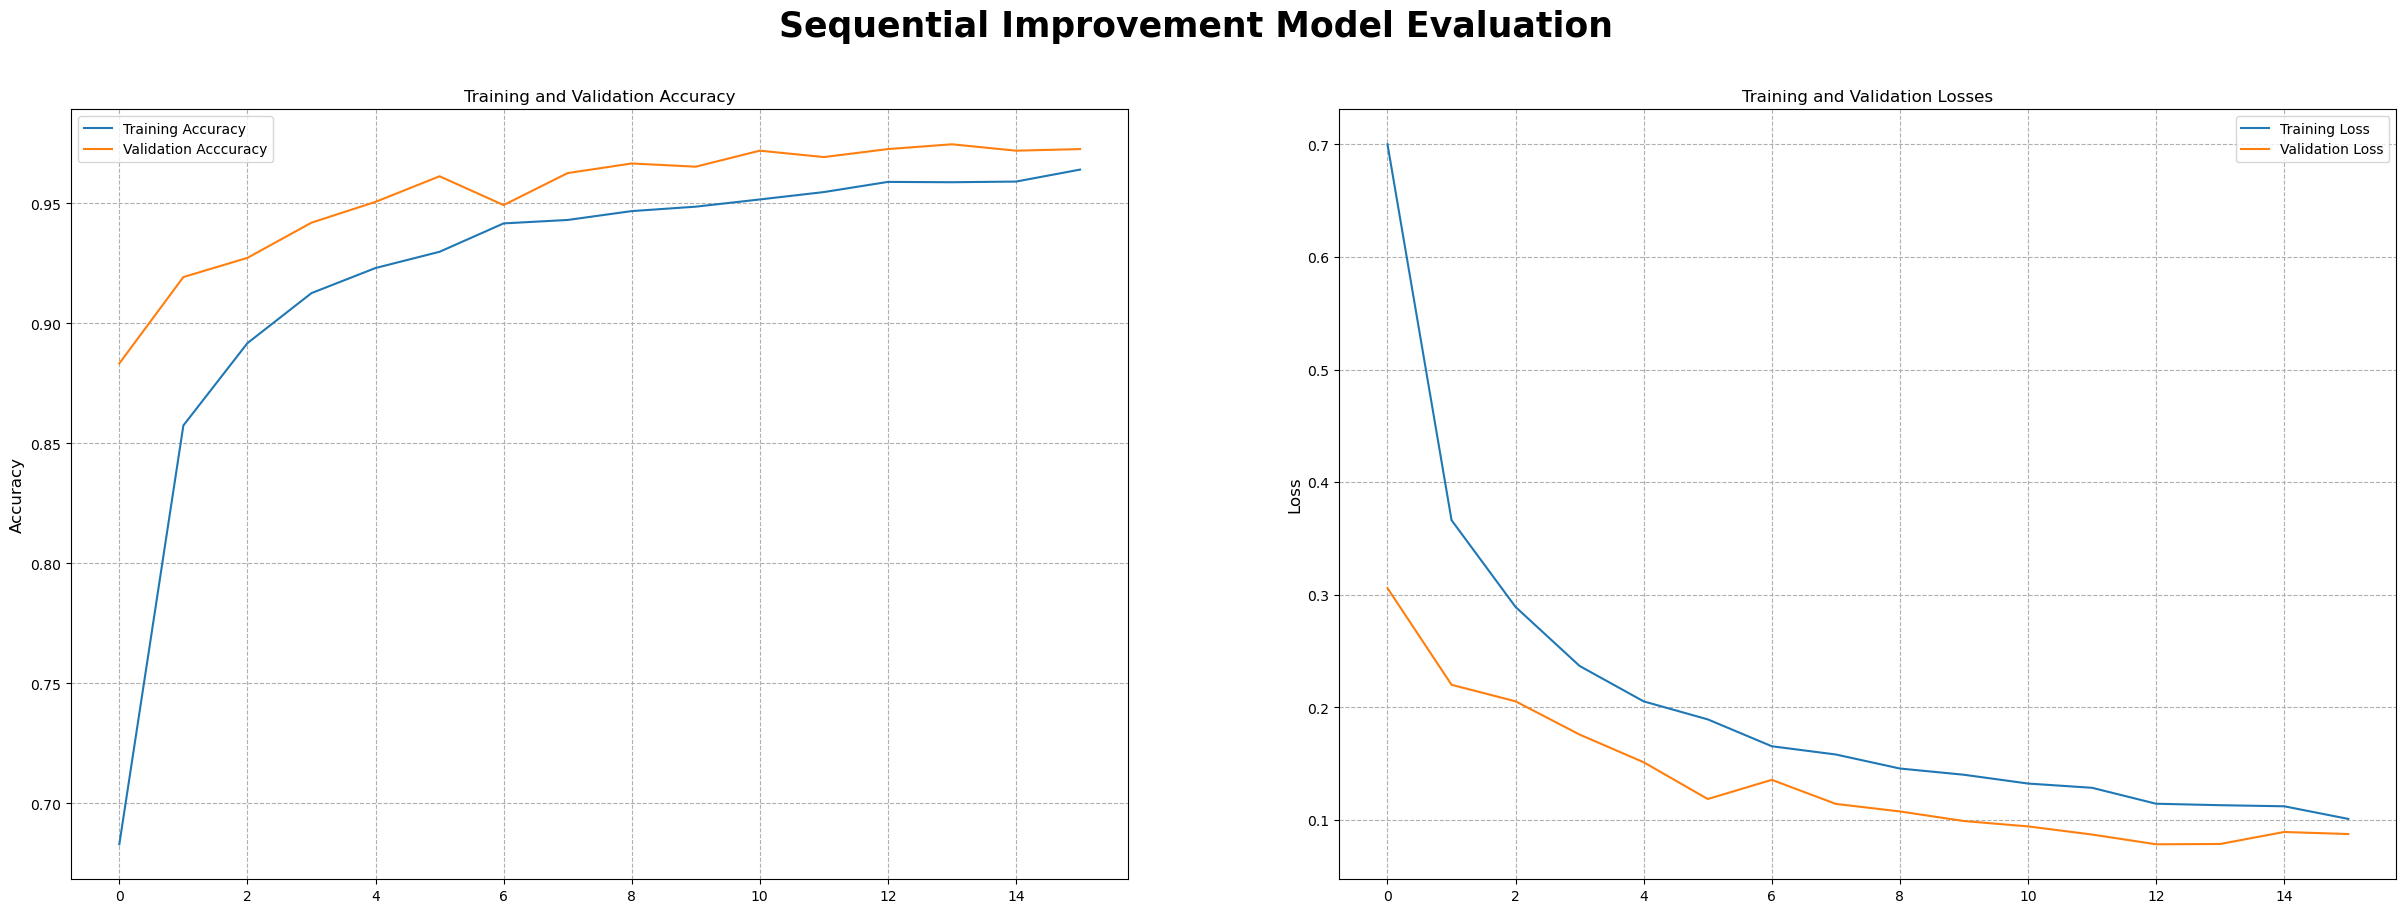

In [72]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Improvement Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_tune.history['accuracy'],label="Training Accuracy")
plt.plot(history_tune.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
# plt.ylim(0.6,1)
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_tune.history['loss'], label="Training Loss")
plt.plot(history_tune.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
# plt.ylim(0,0.6)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

Here in this model improvement we first reduce the batch size to 8, and add 2 more hidden layers for a total of 3. The hidden layers are a multiplication of 2 from 128 to 32. Here we also increase the Epoch to 25, but the callbacks stops at 16 epoch. One of the most noticable difference between the improved and base model is the gap between training and validation accuracy are much closer. In this improvement model we also got around 6% improvement from 0.9032 to 0.9641 train accuracy. Overall the improvement is a success and the model is ready to deploy.

In [73]:
# predict probabilities
y_pred= model_tune.predict(train_image2)

# to label array
y_pred_fin = np.argmax(y_pred,axis=1)

# y train
y_train_fin = y_train['label'].replace({'cat':0,'dog':1,'wild':2})
y_train_fin

# classification report
print("="*10,"TRAIN","="*10)
print(classification_report(y_train_fin, y_pred_fin))


1829/1829 [==============================] - 127s 69ms/step
========== TRAIN ==========
              precision    recall  f1-score   support

           0       0.36      0.35      0.35      5153
           1       0.33      0.34      0.33      4739
           2       0.33      0.32      0.32      4738

    accuracy                           0.34     14630
   macro avg       0.34      0.34      0.34     14630
weighted avg       0.34      0.34      0.34     14630



In [74]:
# predict probabilities
y_pred_val= model_tune.predict(val_image2)

# to label array
y_pred_val_fin = np.argmax(y_pred_val,axis=1)

# y train
y_val_fin = y_val['label'].replace({'cat':0,'dog':1,'wild':2})
y_val_fin

# classification report
print("="*10,"VALIDATION","="*10)
print(classification_report(y_val_fin, y_pred_val_fin))


188/188 [==============================] - 5s 27ms/step
========== VALIDATION ==========
              precision    recall  f1-score   support

           0       0.35      0.36      0.36       500
           1       0.36      0.37      0.37       500
           2       0.32      0.31      0.32       500

    accuracy                           0.35      1500
   macro avg       0.35      0.35      0.35      1500
weighted avg       0.35      0.35      0.35      1500



Here we have the classsification report for train and val, based on the report we can see that the model has almost an equal performance when predicting our 3 category (Cat, Dog, Wild), and as we can see based on our validation the mdoel is better at predicting 1 (Dog), then 0 (Cat), lastly 2 (wild animals)

## Model Saving

In [75]:
model_tune.save('animal_face.h5')

Even though we already have model saving in our callbacks, we do it one more time just to make sure things work well and have backup

## Inference

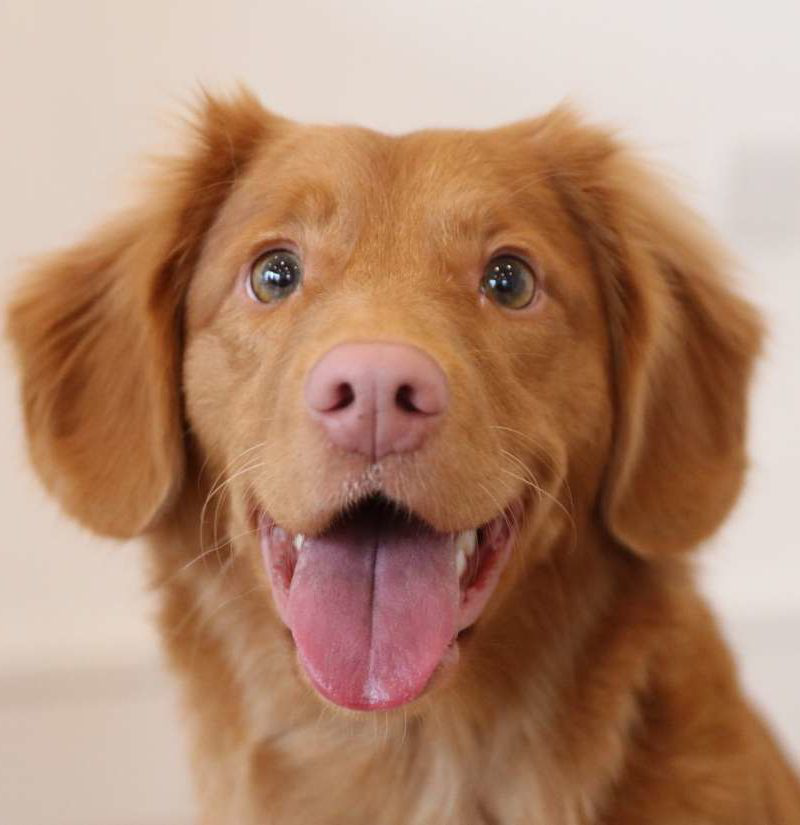

In [76]:
inference = Image.open(r'C:\Code\Milestone2Phase2\Images\inference\image\322868_1100-800x825.jpg')
inference


In [77]:
inference = np.array(inference)

In [78]:
inference_rescale = inference/255 

In [79]:
inference_resize = cv2.resize(inference_rescale,(img_height,img_width))

In [80]:
inference_resize.shape

(224, 224, 3)

In [81]:
inf = model_tune.predict(np.array([inference_resize]))
np.argmax(inf)

1/1 [==============================] - 0s 77ms/step


1

Inference work, predited dog as dog

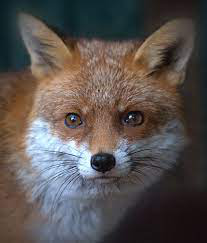

In [82]:
inference2 = Image.open(r'C:\Code\Milestone2Phase2\Images\inference\image\download.jpg')
inference2


In [83]:
inference2 = np.array(inference2)
inference_rescale2 = inference2/255 
inference_resize2 = cv2.resize(inference_rescale2,(img_height,img_width))
inference_resize2.shape

(224, 224, 3)

In [84]:
inf2 = model_tune.predict(np.array([inference_resize2]))
np.argmax(inf2)

1/1 [==============================] - 0s 18ms/step


2

Predicted, wild as wild

## Conclusion

In conclusion, we have suceeded in making a CNN sequential model for detecting types of animal faces. Our objectives was to make a machine learning model to be implemented in our tamer robot so that they can act accordingly when encountering pets or wild animals, and we successfully created a model with 96% accuracy. We use accuracy as our main evaluation metrics because the data is balanced and we want to make sure that our model equally predict all three class correctly, and our model did just that. Which we can see as well in our classification report that our model can almost predict thress classes equally, with a bit better at predicting dogs and cats over wild animal. We want our modlel to equally predict 3 classes because we dont want a failure of prediction that results in our robot to mishandle the situation. For example our robot misclassified a Dog as a Wolf and decide to use its built in tranquilizer at the dog, we do not want this to happen and neither the other way around when our robot encounters wolf but give the wolf a treat because it thinks that the wolf is a dog.

Overall, the model is a success with great base model at around 90% accuracy and even better after the improvement with 96% accuracy. The model is ready to use and has been deployed. Further improvement is possible to reach 99% accuracy, we could probably try increasing the convolutional layers, changing the activation and optimizer to increase our future model. Perhaps by using other model, or a pre-trained model such as ResNet50 we could achieve even better result as well.